In [1]:
%pylab inline
import calin.calib.spe_fit
import calin.math.histogram
import calin.math.optimizer
import calin.math.pdf_1d

Populating the interactive namespace from numpy and matplotlib


## Load data and plot histogram

In [2]:
fernandez_data = loadtxt('../../calib/fernandez_dc_1.5kV_6.45V.dat');
mes_hist = calin.math.histogram.SimpleHist(1.0)
mes_hist.insert_vec(fernandez_data);

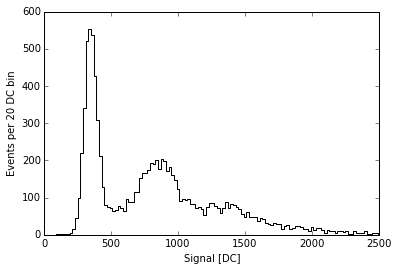

In [3]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_data.pdf')

## Fit of single-Gaussian model

In [4]:
ped_gauss_pdf = calin.math.pdf_1d.GaussianPDF()

In [5]:
ses_g_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
mes_model_g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_g_pdf, ped_gauss_pdf)
like_g = calin.calib.spe_fit.SPELikelihood(mes_model_g, mes_hist)
opt_g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_g)
opt_g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_g.set_abs_tolerance(0.0001);
opt_g.set_initial_values([1.0, 355.0, 10.0, 500.0, 200.0]);
opt_g.set_limits_lo([0.01, 300.0, 0.1, 100.0, 10.0])
opt_g.set_limits_hi([2.0,  400.0, 100.0, 1000.0, 500.0])
status, xopt_g, fval_g = opt_g.minimize()
print(status, xopt_g, fval_g)
status, err_mat_g = opt_g.calc_error_matrix()
xerr_g = sqrt(err_mat_g.diagonal())
print(xerr_g)

Minimization starting using Hello. Naxis = 5.
List of function domain axes: 
Num Name            Lo bound Hi bound Stepsize
0   light_intensity 0.01     2        1       
1   ped.mean        300      400      1       
2   ped.rms         0.1      100.1    1       
3   ses.mean        100      1000     1       
4   ses.rms         10       500      1       
1    81875.361  1          355        10         500        200       
2    81316.763  2          354.96321  10.249637  499.9992   200.00579 
3    80877.349  1.7050732  354.95564  10.305112  499.99777  200.00808 
4    80587.408  1.3335123  354.90642  10.641047  499.993    200.01851 
5    80365.884  1.3313025  354.86351  10.932399  499.98954  200.02701 
6    73673.92   1.1962753  352.24159  28.734784  499.7783   200.54628 
7    73440.755  0.73984342 351.48993  33.951294  499.70738  200.68715 
8    72985.417  0.99248992 351.33102  35.022967  499.69587  200.72002 
9    72838.126  1.0105892  350.89434  38.03016   499.65744  200.80435 
10

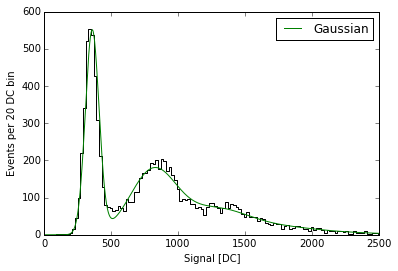

In [6]:
ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))
mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')
legend()
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_gaussian_fit.pdf')

## Fit of exponential/Gaussian model

In [7]:
ses_eg_exp_pdf = calin.math.pdf_1d.LimitedExponentialPDF(0,numpy.inf,mes_hist.dxval())
ses_eg_exp_pdf.limit_scale(0.1, inf);
ses_eg_gauss_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_eg_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_eg_exp_pdf, "exp", ses_eg_gauss_pdf, "gauss")
mes_model_eg = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_eg_pdf, ped_gauss_pdf)
like_eg = calin.calib.spe_fit.SPELikelihood(mes_model_eg, mes_hist)
opt_eg = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", like_eg)
#opt_eg.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_eg.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_eg.set_abs_tolerance(0.0001);
opt_eg.set_max_iterations(1000);
opt_eg.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
opt_eg.set_limits_lo([0.01, 300.0, 0.1, 0.0, 10.0, 100.0, 10.0])
opt_eg.set_limits_hi([2.0,  400.0, 100.1, 1.0, 500.0, 1000.0, 500.0])
status, xopt_eg, fval_eg = opt_eg.minimize()
print(status, xopt_eg, fval_eg)
status, err_mat_eg = opt_eg.calc_error_matrix()
xerr_eg = sqrt(err_mat_eg.diagonal())
print(xerr_eg)

Minimization starting using Hello. Naxis = 7.
List of function domain axes: 
Num Name                Lo bound Hi bound Stepsize
0   light_intensity     0.01     2        1       
1   ped.mean            300      400      1       
2   ped.rms             0.1      100.1    1       
3   ses.exp probability 0        1        1       
4   ses.exp.scale       10       500      1       
5   ses.gauss.mean      100      1000     1       
6   ses.gauss.rms       10       500      1       
1    81082.563  1          355        10         0.1        200        500        200       
2    81050.119  2          354.96089  10.213191  0.98628597 199.99978  500.00116  200.00232 
3    79252.161  2          354.97495  10.127464  0.36879692 200.00083  500.00061  200.00121 
4    79155.666  2          354.96341  10.174769  0.45201889 200.00101  500.00081  200.00156 
5    79103.191  2          354.94054  10.260414  0.50641871 200.00129  500.00127  200.00208 
6    79013.967  2          354.88434  10.465686  0

## Fit of double-Gaussian model

Mean of one of the Gaussians is fixed at zero in the fit

In [8]:
ses_2g_g1_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_g2_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_2g_pdf = calin.math.pdf_1d.TwoComponentPDF(ses_2g_g1_pdf, "g1", ses_2g_g2_pdf, "g2")
mes_model_2g = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_2g_pdf, ped_gauss_pdf)
like_2g = calin.calib.spe_fit.SPELikelihood(mes_model_2g, mes_hist)
freezer = calin.math.function.FreezeThawFunction(like_2g)
freezer.freeze(4,0)
opt_2g = calin.math.optimizer.NLOptOptimizer("LD_LBFGS", freezer)
#opt_2g.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_2g.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_2g.set_abs_tolerance(0.0001);
opt_2g.set_initial_values([1.0, 355.0, 10.0, 0.1, 200.0, 500.0, 200.0]);
status, xopt_2g, fval_2g = opt_2g.minimize()
print(status, xopt_2g, fval_2g)
status, err_mat_2g = opt_2g.calc_error_matrix()
xerr_2g = sqrt(err_mat_2g.diagonal())
print(xerr_2g)

Minimization starting using Hello. Naxis = 7.
List of function domain axes: 
Num Name               Lo bound Hi bound Stepsize
0   light_intensity    0        inf      1       
1   ped.mean           -inf     inf      1       
2   ped.rms            2.22507e-308 inf      1       
3   ses.g1 probability 0        1        1       
4   ses.g1.rms         2.22507e-308 inf      1       
5   ses.g2.mean        -inf     inf      1       
6   ses.g2.rms         2.22507e-308 inf      1       
1    81120.863  1          355        10         0.1        200        500        200       
2    86557.459  2.2445569  354.95138  10.26544   1          199.99936  500.00163  200.00285 
3    80403.297  1.7796361  354.96954  10.166281  0.66379299 199.9996   500.00102  200.00179 
4    79329.931  1.9188809  354.95683  10.218247  0.37320327 199.99989  500.00156  200.00221 
5    79311.044  1.9073881  354.9499   10.244068  0.36728869 199.99979  500.00174  200.00239 
6    79008.69   1.4869636  354.69651  11.18865

## Draw MES and SES plots

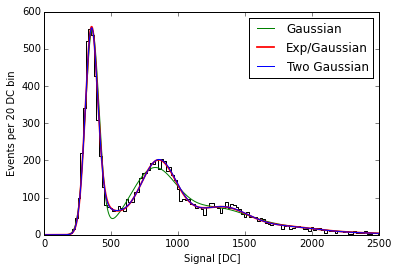

In [9]:
mes_hist_plot = calin.math.histogram.SimpleHist(20.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(0,mes_hist_plot.nbin());
xhist_plot = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist_plot = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist_plot,yhist_plot,'k')
xlabel('Signal [DC]')
ylabel('Events per 20 DC bin')

ihist = range(0,mes_hist.nbin());
xhist = list(map(lambda i: mes_hist.xval_center(i),ihist))

mes_model_g.set_parameter_values(xopt_g)
ymodel_g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_g,'g',lw=1, label='Gaussian')

mes_model_eg.set_parameter_values(xopt_eg)
ymodel_eg = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_eg.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_eg,'r',lw=1.75, label="Exp/Gaussian")

mes_model_2g.set_parameter_values(freezer.x_in2out(xopt_2g))
ymodel_2g = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_2g.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_2g,'b',lw=1, label='Two Gaussian')

legend()
axis([0,2500,0,600])
gcf().savefig('../../../mybuild/fernandez_two_cpt_fits.pdf')

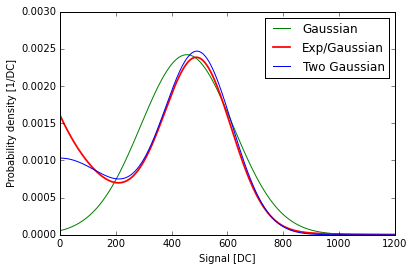

In [10]:
ses_g_y = asarray(mes_model_g.n_electron_spectrum(1));
ses_g_x = ses_g_y*0;
for i in range(0,len(ses_g_y)):
    ses_g_x[i] = mes_model_g.ses_x(i)
plot(ses_g_x, ses_g_y, 'g', label='Gaussian')

ses_eg_y = asarray(mes_model_eg.n_electron_spectrum(1));
ses_eg_x = ses_eg_y*0;
for i in range(0,len(ses_eg_y)):
    ses_eg_x[i] = mes_model_eg.ses_x(i)
plot(ses_eg_x, ses_eg_y, 'r', lw=1.75, label='Exp/Gaussian')

ses_2g_y = asarray(mes_model_2g.n_electron_spectrum(1));
ses_2g_x = ses_2g_y*0;
for i in range(0,len(ses_2g_y)):
    ses_2g_x[i] = mes_model_2g.ses_x(i)
plot(ses_2g_x, ses_2g_y, 'b', label='Two Gaussian')
legend()
axis([0,1200,0,0.003])
xlabel('Signal [DC]')
ylabel('Probability density [1/DC]')
gcf().savefig('../../../mybuild/fernandez_ses.pdf')

## Calculate gain and ENF

**Single Gaussian**

In [11]:
ses_g_norm = sum(ses_g_y)
ses_g_mean = sum(ses_g_y*ses_g_x)
ses_g_rms = sqrt(sum(ses_g_y*ses_g_x*ses_g_x) - ses_g_mean**2)
print("Norm, mean, RMS: ",ses_g_norm, ses_g_mean, ses_g_rms)
print("Resolution: ",ses_g_rms/ses_g_mean)
print("ENF: ",sqrt(1+(ses_g_rms/ses_g_mean)**2))

Norm, mean, RMS:  1.00000003804 456.422854049 163.203822418
Resolution:  0.357571539134
ENF:  1.06200631147


**Exponential/Gaussian**

In [12]:
ses_eg_norm = sum(ses_eg_y)
ses_eg_mean = sum(ses_eg_y*ses_eg_x)
ses_eg_rms = sqrt(sum(ses_eg_y*ses_eg_x*ses_eg_x) - ses_eg_mean**2)
print("Norm, mean, RMS: ",ses_eg_norm, ses_eg_mean, ses_eg_rms)
print("Resolution: ",ses_eg_rms/ses_eg_mean)
print("ENF: ",sqrt(1+(ses_eg_rms/ses_eg_mean)**2))

Norm, mean, RMS:  1.00000000063 399.395135699 202.978840751
Resolution:  0.508215605569
ENF:  1.12173218807


**Double Gaussian**

In [13]:
ses_2g_norm = sum(ses_2g_y)
ses_2g_mean = sum(ses_2g_y*ses_2g_x)
ses_2g_rms = sqrt(sum(ses_2g_y*ses_2g_x*ses_2g_x) - ses_2g_mean**2)
print("Norm, mean, RMS: ",ses_2g_norm, ses_2g_mean, ses_2g_rms)
print("Resolution: ",ses_2g_rms/ses_2g_mean)
print("ENF: ",sqrt(1+(ses_2g_rms/ses_2g_mean)**2))

Norm, mean, RMS:  1.00000000097 408.594093644 190.77971976
Resolution:  0.466917468284
ENF:  1.10363577424
